in linux


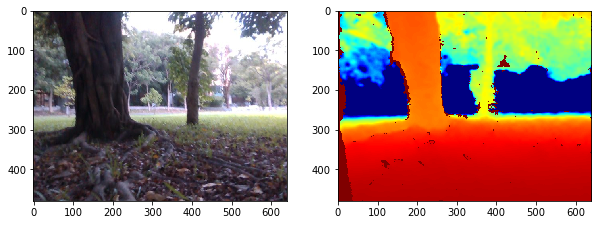

In [11]:
'''math tool'''
import csv
import numpy as np
from scipy.spatial import distance as dist

'''plot tool'''
import matplotlib.pyplot as plt

'''image tool'''
import cv2
import statistics as sta

import utm
from pyproj import Proj
import time
import sys
if sys.platform.startswith('linux'): # or win
    print("in linux")
    file_path = "/home/ncslaber/110-1/211009_allLibrary/front-right/syn_rosbag/"

cx_d = 320.6562194824219 #424
cy_d = 241.57083129882812 #241
fx_d = 384.31365966796875 #424
fy_d = 384.31365966796875 #424

npDepth = np.load(file_path+"depth/2.npy")
npColor = np.load(file_path+"color/2.npy")

npDepthF = cv2.convertScaleAbs(npDepth, alpha=0.02) # 6m
npDepthF_color = cv2.applyColorMap(npDepthF, cv2.COLORMAP_JET)
fig=plt.figure(figsize=(10,10))
subplot = fig.add_subplot(121)
subplot.imshow(npColor)
subplot = fig.add_subplot(122)
subplot.imshow(npDepthF_color)

float16


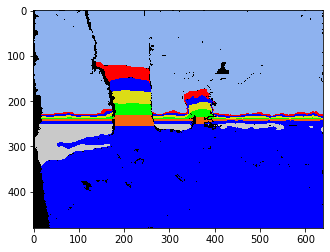

In [12]:
npPointX = np.asarray(range(640))-cx_d
npPointX = np.diag(npPointX)
npPointX = npDepth.dot(npPointX)/ fx_d * (-1)

npPointY = np.asarray(range(480))-cy_d
npPointY = np.diag(npPointY)
theta = 0/180*np.pi
npPointY = npPointY.dot(npDepth)/ fy_d * (-1) 
npPointY = npPointY*np.cos(theta) + npDepth * np.sin(theta) + 410
npPointY = npPointY.astype('float16')

'''depth segmentation'''
npHeight = np.copy(npPointY)
color_seq = {'brown': (0,130,210), 'red':(0,0,255),'yellow':(22,220,220),
                'green':(0,255,0), 'blue':(255,0,0),'black':(0,0,0), 
                'gray':(201,201,201), 'orange':(13,101,245), 'sky':(239,178,142) }
npHeight_seg = np.zeros((npDepth.shape[0],npDepth.shape[1],3))

npHeight_seg[npHeight<-50]=color_seq['gray']
npHeight_seg[np.logical_and(npHeight<300,npHeight>-50)]=color_seq['blue']
npHeight_seg[np.logical_and(npHeight<500,npHeight>300)]=color_seq['orange']
npHeight_seg[np.logical_and(npHeight<700,npHeight>500)]=color_seq['green']
npHeight_seg[np.logical_and(npHeight<900,npHeight>700)]=color_seq['yellow']
npHeight_seg[np.logical_and(npHeight<1100,npHeight>900)]=color_seq['blue']
npHeight_seg[np.logical_and(npHeight<1300,npHeight>1100)]=color_seq['red']
npHeight_seg[npHeight>1300]=color_seq['sky']
npHeight_seg[npHeight==410]=color_seq['black']
# npHeight_seg[np.logical_and(npHeight<0.9,npHeight>-0.9)]=(255,255,255)
# print(*(npDepth[np.logical_and(npHeight<0.9,npHeight>-0.9)]))
print(npHeight.dtype)
npHeight_seg = npHeight_seg.astype('uint8')
%matplotlib inline
plt.imshow(cv2.cvtColor(npHeight_seg, cv2.COLOR_BGR2RGB))


In [4]:
def depth_Z(u,v):
    return npDepth[v][u]

(150, 75)

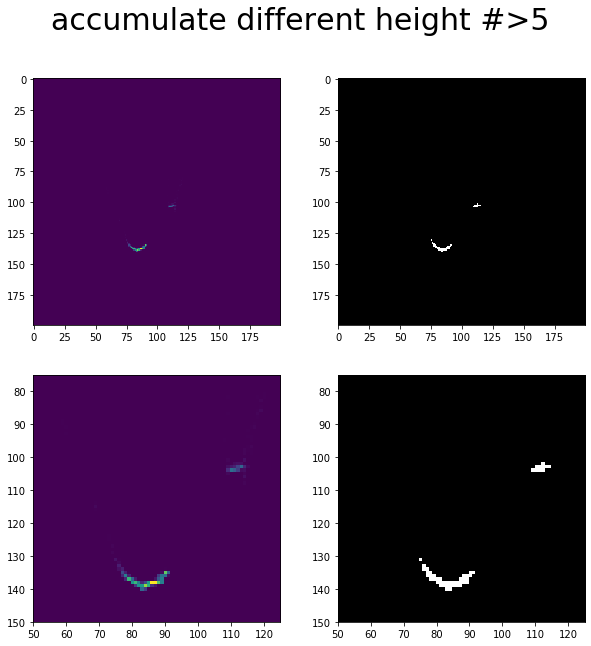

In [35]:
height_layer_tmp = np.logical_and(npHeight<500,npHeight>300)
height_layer = np.logical_and(height_layer_tmp,npHeight!=410)

plane_l1 = np.zeros((int(10/0.05),int(10/0.05)),dtype=np.uint8)

row, column = npDepth.shape
scan_height_ = 10
center_y = row/2
offset = int(center_y - scan_height_/2 );

for v in range(row):#, offset+scan_height_,1
    if height_layer[v].any() == True:
        for u in range(column):
            if height_layer[v][u] == True:
                z_depth = depth_Z(u,v)

                if (z_depth>50 and z_depth<6000):
                    x_depth = (u-cx_d)/fx_d*depth_Z(u,v)
                    plane_l1[200-int(z_depth/50)][int(x_depth/50)+100]+=1
    else:
        pass

fig=plt.figure(figsize=(10,10))
fig.suptitle("accumulate different height #>5", fontsize=30)
subplot = fig.add_subplot(221)
subplot.imshow(plane_l1)

plane_l1_copy = np.zeros((int(10/0.05),int(10/0.05)), dtype=np.uint8)
plane_l1_copy[plane_l1>5]=255
subplot = fig.add_subplot(222)
subplot.imshow(cv2.cvtColor(plane_l1_copy, cv2.COLOR_BGR2RGB))

subplot = fig.add_subplot(223)
subplot.imshow(plane_l1)
plt.xlim((50,125))
plt.ylim((150,75))
subplot = fig.add_subplot(224)
subplot.imshow(cv2.cvtColor(plane_l1_copy, cv2.COLOR_BGR2RGB))
plt.xlim((50,125))
plt.ylim((150,75))